In [1]:
#run 'Pkg.clone("https://github.com/QTL-rocks/QTLDatasets.jl.git")' to get test datasets
using DataFrames
using QTLDatasets
using JWAS.ST

### <font color="red"> Data </font>

### <font color="red"> Run module</font>

### <font color="blue">1. linear model with fixed effects and random effects</font>

In [2]:
phenofile = QTLDatasets.dataset("testMME","data.txt")
data      = readtable(phenofile,separator = ',',header=true)

,sow,site,yr,age,geneticCode,parity,nwn,SYS
1,100-113,113,2005,18,PIC 1,1,8,113_2005_WNTR
2,100-113,113,2006,18,PIC 1,2,12,113_2006_SPNG
3,100-5,5,2008,15,PIC 2,1,10,5_2008_ATMN
4,1000-5,5,2009,17,PIC 2,1,10,5_2009_SPNG
5,10000-13,13,2004,16,Commercial,1,9,13_2004_WNTR
6,10000-13,13,2004,18,Commercial,2,10,13_2004_SMMR
7,10000-13,13,2004,20,Commercial,3,11,13_2004_ATMN
8,10000-13,13,2005,18,Commercial,4,11,13_2005_SPNG
9,10000-13,13,2005,25,Commercial,5,7,13_2005_ATMN
10,10000-6,6,2012,17,PIC C27,1,12,6_2012_ATMN


In [3]:
model  = "nwn = intercept + parity + site + yr + geneticCode + age + sow + SYS"
varRes = 2.97      # starting value for residual variance
mme    = build_model(model,varRes)

set_covariate(mme,"age")

ν      = 4.0       # degrees of freedom for prior of variance components
v1     = 0.26      # starting value for sow variance
set_random(mme,"sow",v1,ν)
v2     = 0.28      # starting value for SYS variance
set_random(mme,"SYS",v1,ν);

In [4]:
outputMCMCsamples(mme,"parity","age");
out=runMCMC(mme,data,chain_length=50000,printout_frequency=5000);

at sample: 5000 with meanVare: 3.0075609370906773
at sample: 10000 with meanVare: 2.95564869076031
at sample: 15000 with meanVare: 2.8712946270482007
at sample: 20000 with meanVare: 2.9279356885432644
at sample: 25000 with meanVare: 2.888042755110165
at sample: 30000 with meanVare: 2.8999656589097156
at sample: 35000 with meanVare: 2.9237384122446812
at sample: 40000 with meanVare: 2.898600031266992
at sample: 45000 with meanVare: 2.8908443742665737
at sample: 50000 with meanVare: 2.9139714560583156


In [5]:
keys(out)

Base.KeyIterator for a Dict{Any,Any} with 6 entries. Keys:
  "Posterior Mean of Location Parameters"
  "MCMC samples for residual variance"
  "MCMC samples for: parity"
  "MCMC samples for: variance of SYS"
  "MCMC samples for: age"
  "MCMC samples for: variance of sow"

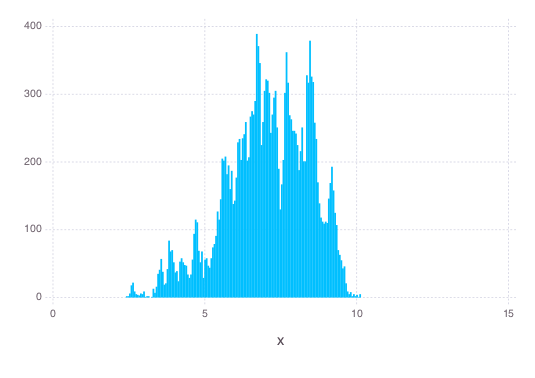

In [7]:
using Gadfly
sample4age = out["MCMC samples for: age"]
plot(x=sample4age[30000:end], Geom.histogram)

### <font color="blue">2. Pedigree-based BLUP</font>

In [8]:
pedfile   = QTLDatasets.dataset("testMME","pedigree.txt")
phenofile = QTLDatasets.dataset("testMME","simple.txt");

In [9]:
;cat $pedfile

S1 0 0
D1 0 0
O1 S1 D1
O2 S1 D1
O3 S1 D1


In [10]:
d1 = readtable(phenofile)

,Animal,Age,y
1,S1,1,-0.92
2,D1,2,-1.05
3,O1,3,-0.92
4,O3,2,1.2


In [11]:
ped = get_pedigree(pedfile);

In [12]:
varRes=1.0
mme = build_model("y = intercept + Age + Animal",varRes)
set_covariate(mme,"Age")
G=1.0
set_random(mme,"Animal",ped,G)

In [13]:
out = solve(mme,d1,solver="GaussSeidel",printout_frequency=40)

40 1.8911625184083552e-6


7x2 Array{Any,2}:
 "intercept: intercept"  -0.748707  
 "Age: Age"               0.113636  
 "Animal: S1"             0.0594527 
 "Animal: D1"            -0.0624243 
 "Animal: O1"            -0.171724  
 "Animal: O3"             0.572822  
 "Animal: O2"            -0.00148579

### <font color="blue">3. Repeated Measures</font>

In [14]:
phenofile = QTLDatasets.dataset("testMME","repeated_measures.txt")
d2 = readtable(phenofile)

,Animal,Age,y
1,S1,1,-0.92
2,S1,2,-1.35
3,S1,3,-0.33
4,D1,1,-0.3
5,D1,2,-1.05
6,D1,3,0.56
7,O1,1,-0.09
8,O1,2,0.44
9,O1,3,-0.92
10,O3,1,-0.2


In [15]:
varRes=1.0
mme = build_model("y = intercept + Age + Animal + Animal*Age",varRes)
set_covariate(mme,"Age")
G = [1 0.1; 0.1 1.0]
set_random(mme,"Animal Animal*Age",ped,G)

In [16]:
out = solve(mme,d2,solver="Jacobi",printout_frequency=40)

40 0.004079837352814904
80 0.0008468686195409121
120 0.00026899969970286267
160 9.606419899377913e-5
200 3.649498312582733e-5
240 1.4825947812909268e-5
280 6.569648963398997e-6
320 3.2261059576412398e-6
360 1.7555444111655143e-6
400 1.0411088953585247e-6


12x2 Array{Any,2}:
 "intercept: intercept"  -0.590464   
 "Age: Age"               0.0738261  
 "Animal: S1"            -0.0839778  
 "Animal: D1"             0.0822513  
 "Animal: O1"             0.191167   
 "Animal: O3"             0.204641   
 "Animal: O2"            -0.000908243
 "Animal*Age: S1"        -0.0943315  
 "Animal*Age: D1"         0.099499   
 "Animal*Age: O1"        -0.0351528  
 "Animal*Age: O3"         0.267083   
 "Animal*Age: O2"         0.00261206 

### <font color="blue">4. Maternal effects</font>

In [17]:
phenofile = QTLDatasets.dataset("testMME","maternal_effects.txt")
d3 = readtable(phenofile)

,Animal,Age,y,Dam
1,S1,1,-0.92,0
2,S1,2,-1.35,0
3,S1,3,-0.33,0
4,D1,1,-0.3,0
5,D1,2,-1.05,0
6,D1,3,0.56,0
7,O1,1,-0.09,D1
8,O1,2,0.44,D1
9,O1,3,-0.92,D1
10,O3,1,-0.2,D1


In [18]:
;cat $pedfile

S1 0 0
D1 0 0
O1 S1 D1
O2 S1 D1
O3 S1 D1


In [19]:
varRes = 1.0
mme1 = build_model("y = intercept + Animal",varRes);
lhs,rhs= showMME(mme1,d3);
println(full(lhs))

[12.0 3.0 3.0 3.0 3.0
 3.0 3.0 0.0 0.0 0.0
 3.0 0.0 3.0 0.0 0.0
 3.0 0.0 0.0 3.0 0.0
 3.0 0.0 0.0 0.0 3.0]


In [24]:
varRes = 1.0
mme = build_model("y = intercept + Animal + Dam",varRes);

In [26]:
G = [1 0.1; 0.1 1.0]
set_random(mme,"Animal Dam",ped,G)
lhs,rhs=showMME(mme,d3);
println(full(round(lhs,2)))

[12.0 3.0 3.0 3.0 3.0 0.0 0.0 6.0 0.0 0.0 0.0
 3.0 5.53 1.52 -1.01 -1.01 -1.01 -0.25 -0.15 0.1 0.1 0.1
 3.0 1.52 5.53 -1.01 -1.01 -1.01 -0.15 -0.25 0.1 0.1 0.1
 3.0 -1.01 -1.01 5.02 0.0 0.0 0.1 3.1 -0.2 0.0 0.0
 3.0 -1.01 -1.01 0.0 5.02 0.0 0.1 3.1 0.0 -0.2 0.0
 0.0 -1.01 -1.01 0.0 0.0 2.02 0.1 0.1 0.0 0.0 -0.2
 0.0 -0.25 -0.15 0.1 0.1 0.1 2.53 1.52 -1.01 -1.01 -1.01
 6.0 -0.15 -0.25 3.1 3.1 0.1 1.52 8.53 -1.01 -1.01 -1.01
 0.0 0.1 0.1 -0.2 0.0 0.0 -1.01 -1.01 2.02 0.0 0.0
 0.0 0.1 0.1 0.0 -0.2 0.0 -1.01 -1.01 0.0 2.02 0.0
 0.0 0.1 0.1 0.0 0.0 -0.2 -1.01 -1.01 0.0 0.0 2.02]


In [27]:
out = solve(mme,d3,solver="Gibbs",printout_frequency=1000)

at sample: 1000
at sample: 2000
at sample: 3000
at sample: 4000
at sample: 5000


11x2 Array{Any,2}:
 "intercept: intercept"  -0.532945 
 "Animal: S1"            -0.205156 
 "Animal: D1"             0.25941  
 "Animal: O1"            -0.0563897
 "Animal: O3"             0.318543 
 "Animal: O2"             0.0272689
 "Dam: S1"               -0.0462454
 "Dam: D1"                0.453641 
 "Dam: O1"                0.190362 
 "Dam: O3"                0.23191  
 "Dam: O2"                0.206744 